In [82]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [83]:
state = 'GJ'

In [84]:
c_dataset = pd.read_csv("Confirmed - copy.csv")
c_dataset['Date'] = pd.to_datetime(c_dataset['Date'], infer_datetime_format=True)
c_data = c_dataset.set_index(['Date'])
c_data = c_data[[state]]
c_data[state] = c_data[state].fillna(0)

In [85]:
cases = c_data[state].resample('D').mean()#D,W,MS

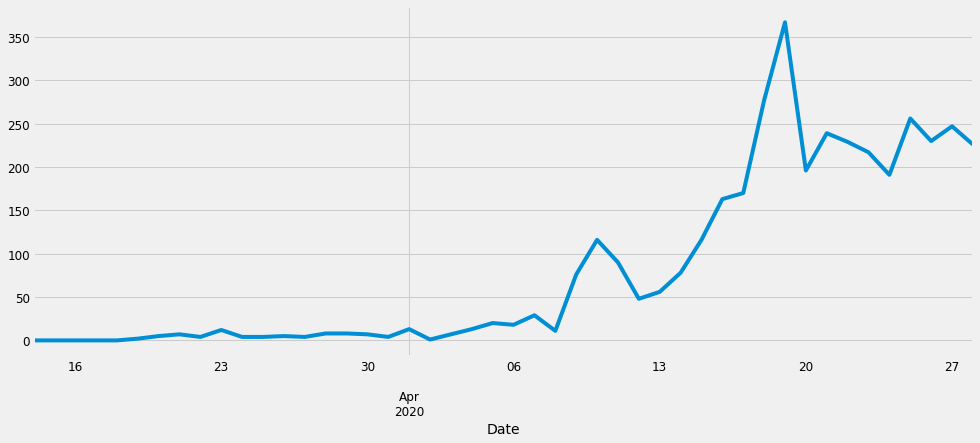

In [86]:
cases.plot(figsize=(15, 6))
plt.show()

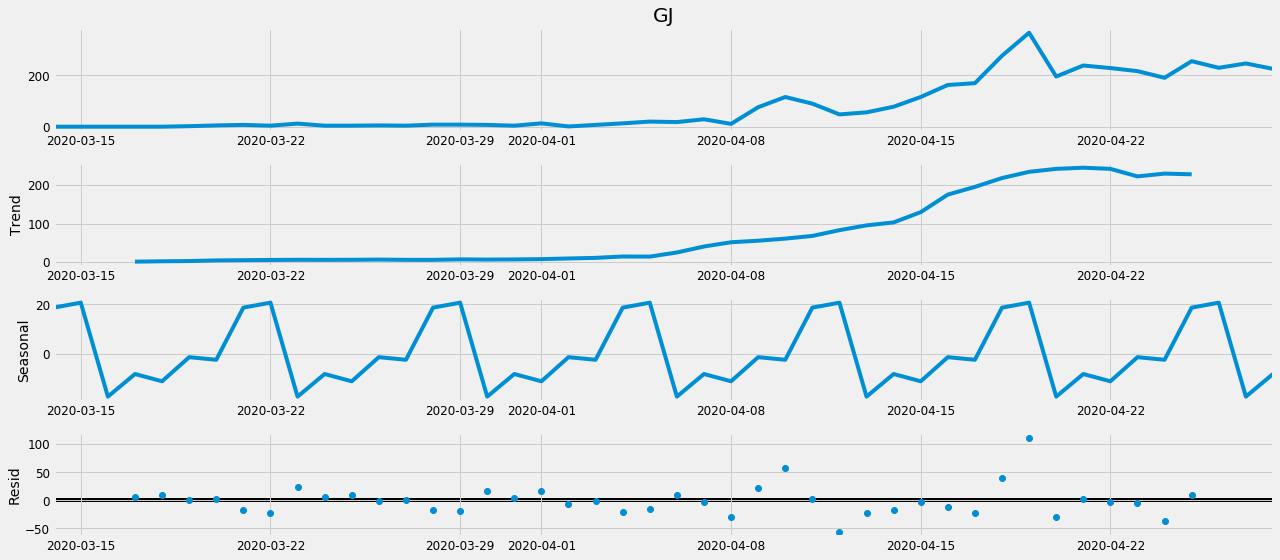

In [87]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
c_decomposition = sm.tsa.seasonal_decompose(cases, model='additive')
c_fig = c_decomposition.plot()
plt.show()

In [88]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [89]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            cases_mod = sm.tsa.statespace.SARIMAX(cases,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            cases_results = cases_mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, cases_results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:569.1432100059749
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1239.189065349649
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:411.0398461476155
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:268.5070700577216
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:409.04823673164935
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1088.6480960553577
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:276.89502905972586
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:267.54706512275953
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:518.4468775589189
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2531.4054017127246
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:371.98220462342454
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:241.38272790233955
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:384.5200815504098
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2951.3628019302037
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:261.88646097416455
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:241.7082337092943
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:451.66388309984325
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1313.928081857504


In [90]:
c_mod = sm.tsa.statespace.SARIMAX(cases,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
cases_results = c_mod.fit()
print(cases_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7427      1.248      0.595      0.552      -1.702       3.188
ma.L1         -1.1445      1.507     -0.760      0.447      -4.097       1.808
ma.S.L12      -0.4109      1.206     -0.341      0.733      -2.775       1.954
sigma2      2296.4536   5895.311      0.390      0.697   -9258.143    1.39e+04


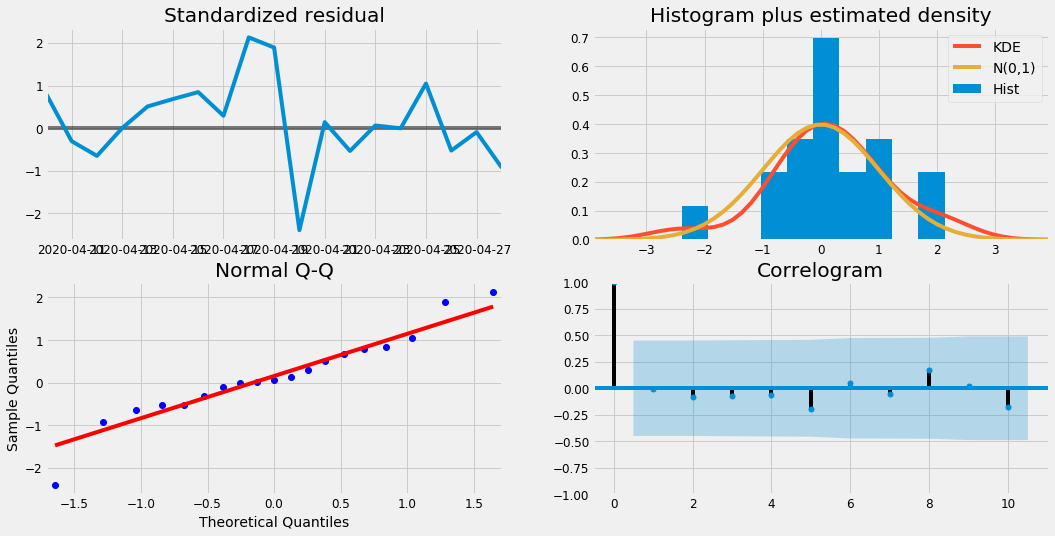

In [91]:
cases_results.plot_diagnostics(figsize=(16, 8))
plt.show()

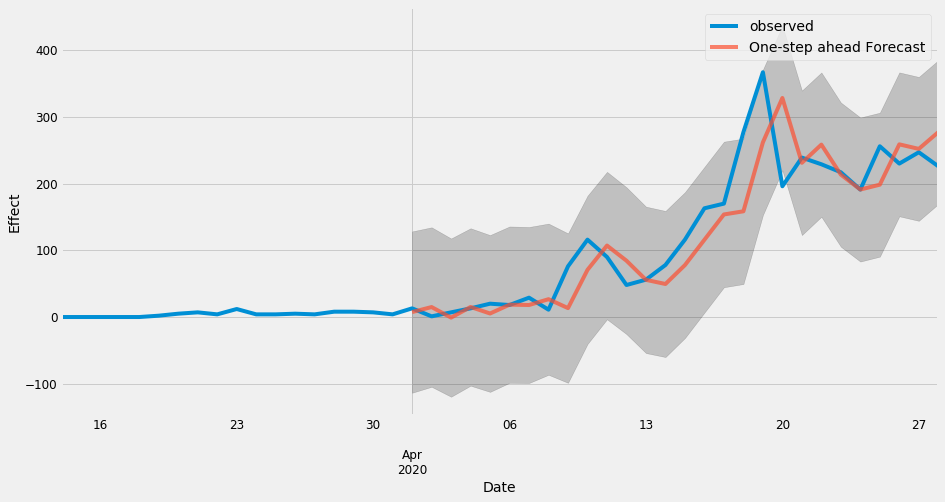

In [92]:
cases_pred = cases_results.get_prediction(start=pd.to_datetime('2020-04-01'), dynamic=False)
cases_pred_ci = cases_pred.conf_int()
cases_ax = cases['2020':].plot(label='observed')
cases_pred.predicted_mean.plot(ax=cases_ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.2)
cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [93]:
cases_forecasted = cases_pred.predicted_mean
cases_truth = cases['2020-04-01':]
cases_mse = ((cases_forecasted - cases_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(cases_mse, 2)))

The Mean Squared Error of our forecasts is 2270.78


In [94]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(cases_mse), 2)))

The Root Mean Squared Error of our forecasts is 47.65


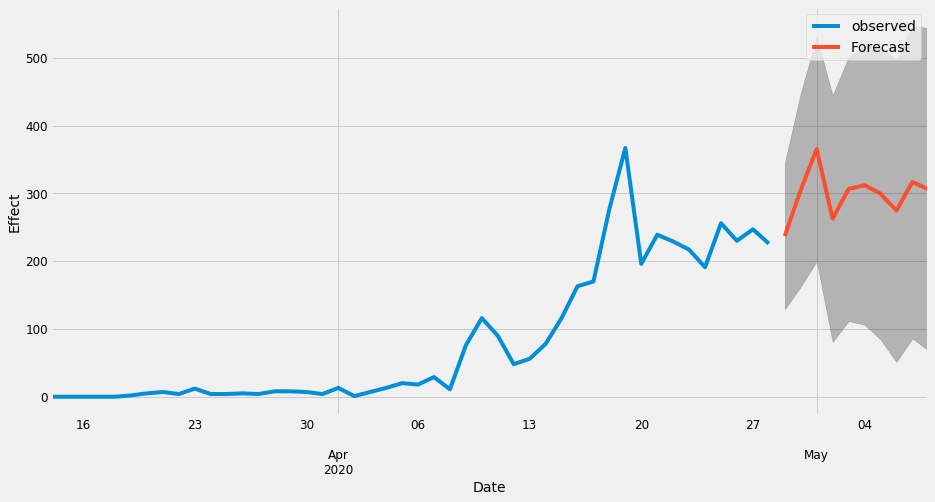

In [95]:
cases_pred_uc = cases_results.get_forecast(steps=10)
cases_pred_ci = cases_pred_uc.conf_int()
cases_ax = cases.plot(label='observed', figsize=(14, 7))
cases_pred_uc.predicted_mean.plot(ax=cases_ax, label='Forecast')
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.25)
cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [96]:
r_dataset = pd.read_csv("Recovered.csv")
r_dataset['Date'] = pd.to_datetime(r_dataset['Date'], infer_datetime_format=True)
r_data = r_dataset.set_index(['Date'])
r_data = r_data[[state]]
r_data[state] = r_data[state].fillna(0)

In [97]:
total_data = pd.DataFrame()
total_data['Cases'] = c_data[state]
total_data['Recovered'] = r_data[state]

In [98]:
total_data.tail()

,Cases,Recovered
Date,,
2020-04-24,191,7
2020-04-25,256,17
2020-04-26,230,31
2020-04-27,247,81
2020-04-28,226,40


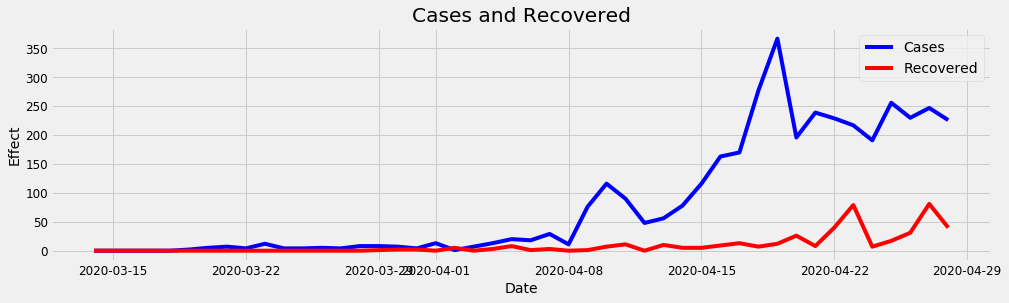

In [99]:
plt.figure(figsize=(15, 4))
plt.plot(total_data.index, total_data['Cases'], 'b-', label = 'Cases')
plt.plot(total_data.index, total_data['Recovered'], 'r-', label = 'Recovered')
plt.xlabel('Date'); plt.ylabel('Effect'); plt.title('Cases and Recovered')
plt.legend()
plt.show()

In [100]:
recovered = total_data['Recovered'].resample('D').mean()

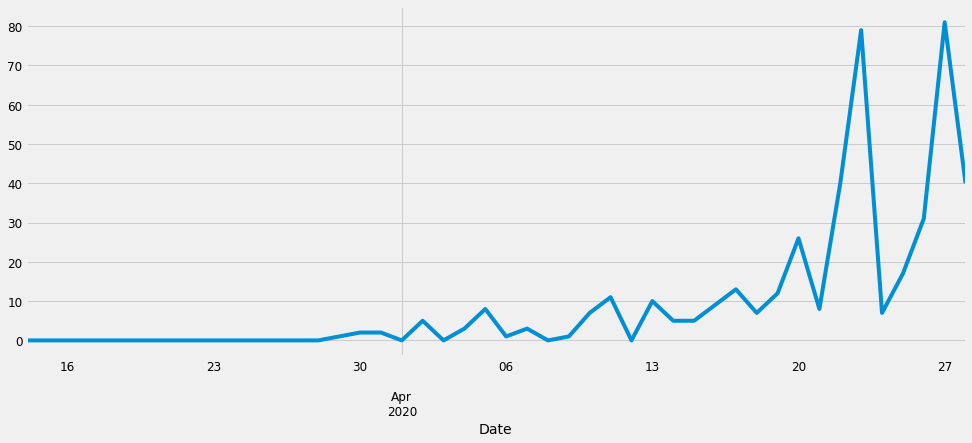

In [101]:
recovered.plot(figsize=(15, 6))
plt.show()

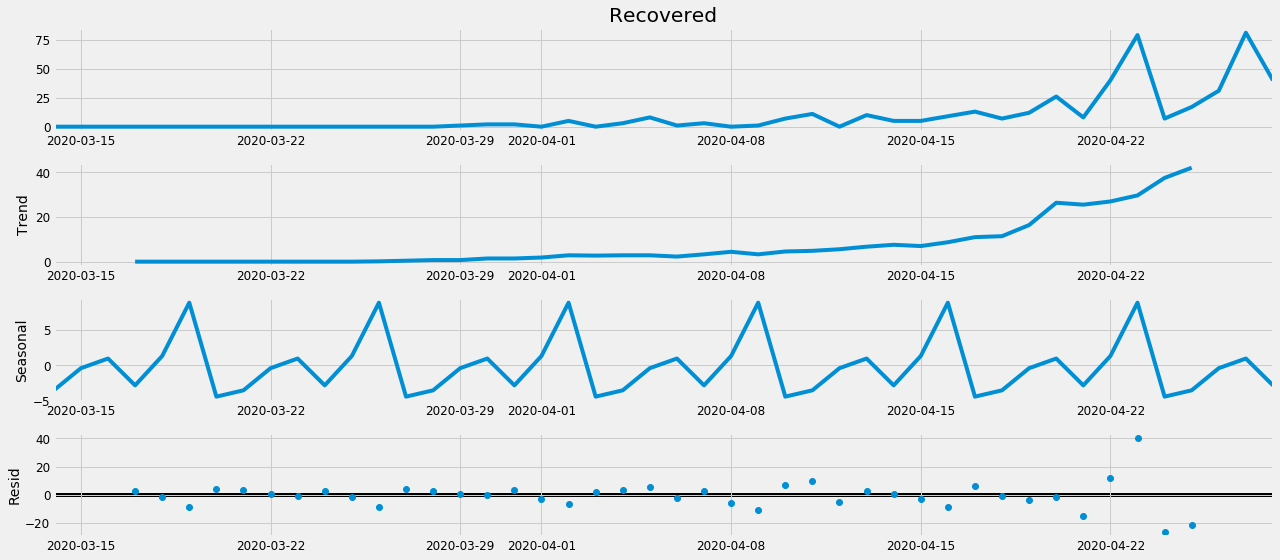

In [102]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
recovered_decomposition = sm.tsa.seasonal_decompose(recovered, model='additive')
fig = recovered_decomposition.plot()
plt.show()

In [103]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            recovered_mod = sm.tsa.statespace.SARIMAX(recovered,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            recovered_results = recovered_mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, recovered_results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:401.5682805342171
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1572.7907835585543
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:296.44753419531446
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:199.2431297710598
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:282.1905436257147
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1217.5048258683155
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:197.16109786902186
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:190.98247056795338
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:379.4924751746477
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1636.367264951931
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:279.3920650317945
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:185.05751824875327
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:284.14520675849565
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.564239958834
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:196.33765300843672
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:181.6450829366167
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:378.0657366763175
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1373.0728579775346
A

In [104]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:199.83565329572556
recovered_mod = sm.tsa.statespace.SARIMAX(recovered,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
recovered_results = recovered_mod.fit()
print(recovered_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      0.644      0.077      0.939      -1.213       1.312
ma.L1         -1.3336      0.702     -1.900      0.057      -2.709       0.042
ma.S.L12       0.4273      2.248      0.190      0.849      -3.979       4.833
sigma2       216.7865    208.040      1.042      0.297    -190.964     624.537


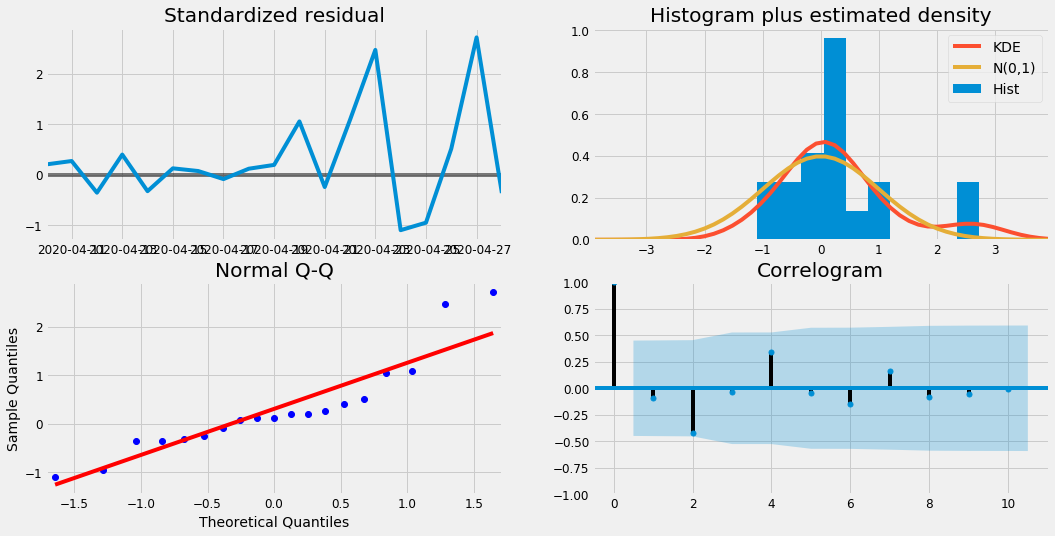

In [105]:
recovered_results.plot_diagnostics(figsize=(16, 8))
plt.show()

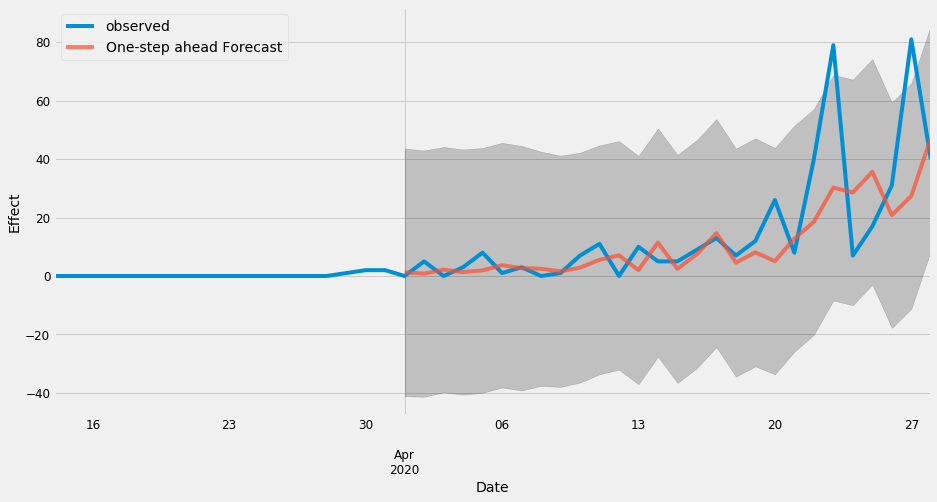

In [106]:
recovered_pred = recovered_results.get_prediction(start=pd.to_datetime('2020-04-01'), dynamic=False)
recovered_pred_ci = recovered_pred.conf_int()
recovered_ax = recovered['2020':].plot(label='observed')
recovered_pred.predicted_mean.plot(ax=recovered_ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='k', alpha=.2)
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [107]:
recovered_forecasted = recovered_pred.predicted_mean
recovered_truth = recovered['2020-04-01':]
recovered_mse = ((recovered_forecasted - recovered_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(recovered_mse, 2)))

The Mean Squared Error of our forecasts is 266.27


In [108]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(recovered_mse), 2)))

The Root Mean Squared Error of our forecasts is 16.32


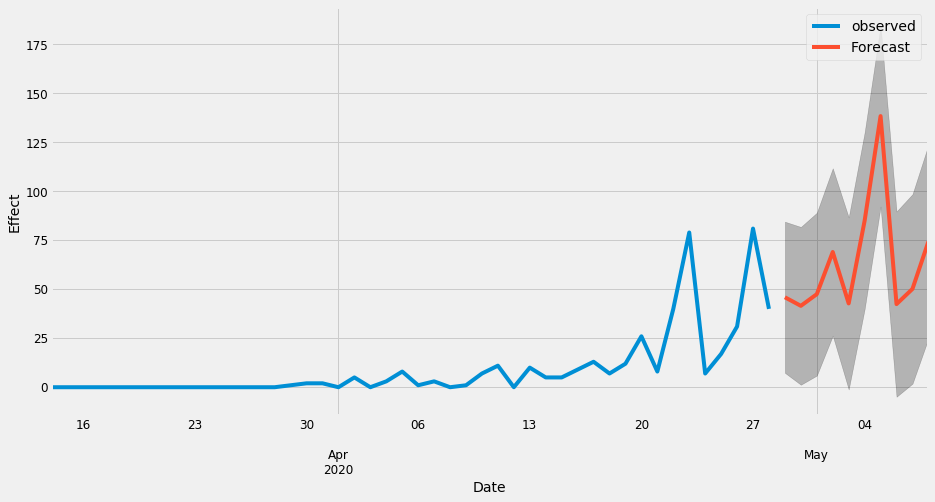

In [109]:
recovered_pred_uc = recovered_results.get_forecast(steps=10)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_ax = recovered.plot(label='observed', figsize=(14, 7))
recovered_pred_uc.predicted_mean.plot(ax=recovered_ax, label='Forecast')
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='k', alpha=.25)
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

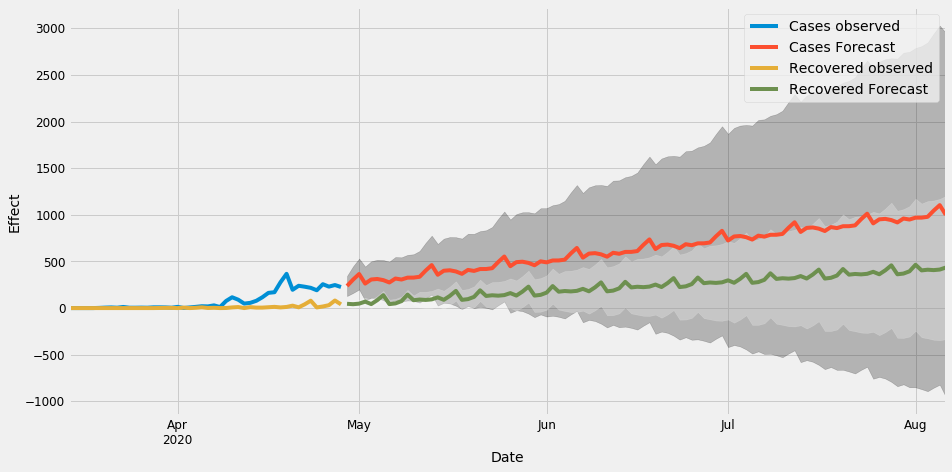

In [110]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_ax = cases.plot(label='Cases observed', figsize=(14, 7))
cases_pred_uc.predicted_mean.plot(ax=cases_ax, label='Cases Forecast')
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.25)

recovered_pred_uc = recovered_results.get_forecast(steps=100)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_ax = recovered.plot(label='Recovered observed', figsize=(14, 7))
recovered_pred_uc.predicted_mean.plot(ax=recovered_ax, label='Recovered Forecast')
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='w', alpha=.25)

cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [111]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_result_date = pd.DataFrame(cases_pred_uc.predicted_mean)

In [112]:
cases_end_date = str(cases_result_date.index[cases_result_date[0]<=0.0].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

IndexError: list index out of range

In [113]:
int(np.mean(cases_result_date)[0])

642

In [114]:
int(min(cases_result_date[0]))

236

In [115]:
cases_end_date = str(cases_result_date.index[cases_result_date[0]<=np.ceil(min(cases_result_date[0]))].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

The predicted last date on which the cases will become 0 is: 2020-04-29


In [116]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_result_date = pd.DataFrame(cases_pred_uc.predicted_mean)

recovered_pred_uc = recovered_results.get_forecast(steps=100)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_result_date = pd.DataFrame(recovered_pred_uc.predicted_mean)

In [117]:
cases_end_date = str(cases_result_date.index[recovered_result_date[0]>=int(np.mean(cases_result_date)[0])].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

IndexError: list index out of range

In [118]:
cases_end_date = str(cases_result_date.index[recovered_result_date[0]>=int(np.mean(recovered_result_date)[0])].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

The predicted last date on which the cases will become 0 is: 2020-06-10
